**Calculating free energy and probabilities**

In [7]:
from IPython.display import SVG
import RNA
import math
import random

In [8]:
# Global constants (R in kcal/(mol*K), T in Kelvin)
R_CONST = 0.0019872   # kcal/(mol*K)
T_CONST = 310.15      # ~37°C

In [4]:
# Create a fold compound for an RNA sequence
seq = "GCGCGAUACG"
fc = RNA.fold_compound(seq)

# Define a test structure (dot-bracket notation)
struct = "((....)).."

# Evaluate the free energy of the structure
energy = fc.eval_structure(struct)
print("Free energy: {:.2f} kcal/mol".format(energy))

Free energy: 6.40 kcal/mol


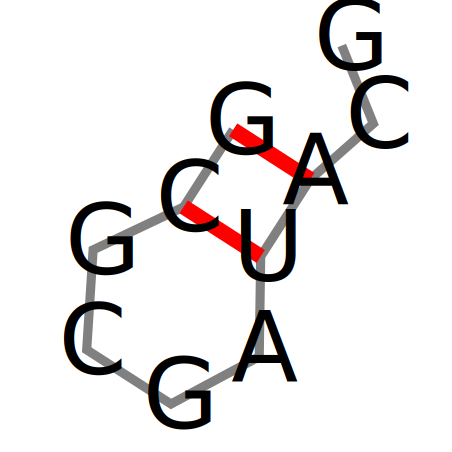

In [5]:
RNA.svg_rna_plot(seq, structure=struct, ssfile="tmp.svg")
SVG("tmp.svg")

In [29]:
def is_complementary(a, b):
    """Check if bases a and b are complementary."""
    valid_pairs = {('A','U'), ('U','A'), ('G','C'), ('C','G'), ('G','U'), ('U','G')}
    return (a, b) in valid_pairs

In [30]:
def dotbracket_to_pt(structure):
    """
    Convert a dot-bracket string to a pair table.
    Returns a list 'pt' of length n+1 (1-indexed; pt[0] is unused).
    For each i (1-indexed), pt[i] = j if base i is paired with j, else 0.
    """
    n = len(structure)
    pt = [0]*(n+1)
    stack = []
    for i, char in enumerate(structure, start=1):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                pt[i] = j
                pt[j] = i
    return pt

In [31]:
dotbracket_to_pt("((....))..")

[0, 8, 7, 0, 0, 0, 0, 2, 1, 0, 0]

In [32]:
def generate_moves(seq, structure):
    """
    Given a sequence and a current structure (in dot-bracket notation),
    generate every valid outcome with one base move (either addition or removal of a single base pair).
    
    Returns a list of tuples: (new_structure, move_type, (i, j))
    where move_type is either 'add' or 'remove', and (i, j) indicates the base pair changed.
    Positions are 1-indexed.
    """
    moves = []
    n = len(structure)
    # Convert structure to a pair table (1-indexed)
    pt = dotbracket_to_pt(structure)
    
    # --- Removal moves: remove an existing base pair ---
    # For every base i that is paired (and to avoid duplicates, ensure i < pt[i])
    for i in range(1, n+1):
        j = pt[i]
        if j > i:
            # Create new structure by removing the pair (i, j)
            new_struct = list(structure)
            new_struct[i-1] = '.'
            new_struct[j-1] = '.'
            moves.append((''.join(new_struct), 'remove', (i, j)))
    
    # --- Addition moves: add one new base pair ---
    # We consider all candidate pairs (i, j) with j - i >= 4 (minimum hairpin length constraint)
    for i in range(1, n+1):
        # Only consider i if currently unpaired
        if pt[i] != 0:
            continue
        for j in range(i+3, n+1):
            if pt[j] != 0:
                continue
            # Check if the bases are complementary
            if not is_complementary(seq[i-1], seq[j-1]):
                continue
            
            # Check that adding (i, j) does not cross any existing base pair.
            # For each existing base pair (k, l) (with k < l), ensure that both k and l lie entirely inside [i, j]
            # or entirely outside [i, j]. If one lies inside and the other outside, the new pair would cross.
            conflict = False
            for k in range(1, n+1):
                l = pt[k]
                if l > k:  # (k, l) is an existing pair
                    in_i = (i < k < j)
                    in_j = (i < l < j)
                    if in_i != in_j:
                        conflict = True
                        break
            if conflict:
                continue
            
            # Otherwise, adding (i, j) yields a valid structure.
            new_struct = list(structure)
            new_struct[i-1] = '('
            new_struct[j-1] = ')'
            moves.append((''.join(new_struct), 'add', (i, j)))
    
    return moves

In [33]:
generate_moves("GCGCUAUACG", "..........")

[('(..)......', 'add', (1, 4)),
 ('(...).....', 'add', (1, 5)),
 ('(.....)...', 'add', (1, 7)),
 ('(.......).', 'add', (1, 9)),
 ('.(.......)', 'add', (2, 10)),
 ('..(...)...', 'add', (3, 7)),
 ('..(.....).', 'add', (3, 9)),
 ('...(.....)', 'add', (4, 10)),
 ('....(..)..', 'add', (5, 8)),
 ('....(....)', 'add', (5, 10)),
 ('......(..)', 'add', (7, 10))]

In [19]:
def move_probabilities(moves, fc):
    """
    For each move outcome in 'moves' (list of (new_structure, move_type, (i, j))),
    compute the free energy using the ViennaRNA fold compound 'fc' and return the probability
    for each move according to the Boltzmann law.
    
    Returns a list of probabilities corresponding to the moves.
    """
    energies = []
    for new_struct, move_type, pos in moves:
        # Evaluate free energy of the outcome structure using ViennaRNA.
        # fc.eval_structure() returns energy in kcal/mol.
        E = fc.eval_structure(new_struct)
        energies.append(E)
    
    # Compute Boltzmann weight for each outcome: weight = exp(-E/(R*T))
    weights = [math.exp(-E/(R_CONST * T_CONST)) for E in energies]
    total = sum(weights)
    probabilities = [w/total for w in weights] if total != 0 else [0]*len(weights)
    return probabilities

In [20]:
move_probabilities(generate_moves("GCGCUGAUACG", "((.....)).."), fc)

[0, 0]

In [21]:
def select_next_structure(seq, current_structure, fc):
    """
    Given a sequence and current structure, generate all one-base moves,
    compute their Boltzmann probabilities, and randomly select one move according
    to these probabilities.
    
    Returns the new structure and the move information (move_type, positions).
    If no moves are available, returns the current structure and None.
    """
    moves = generate_moves(seq, current_structure)
    if not moves:
        return current_structure, None
    probs = move_probabilities(seq, current_structure, moves, fc)
    r = random.random()
    cumulative = 0.0
    for move, prob in zip(moves, probs):
        cumulative += prob
        if r <= cumulative:
            return move[0], (move[1], move[2])
    return moves[-1][0], (moves[-1][1], moves[-1][2])

In [22]:
# Create the ViennaRNA fold compound for our sequence.
fc = RNA.fold_compound(seq)

# 1) Generate all one-base moves
moves = generate_moves(seq, init_struct)
print("Generated Moves:")
for m in moves:
    print(m)

# 2) Compute probabilities for each move based on Boltzmann law
probs = move_probabilities(seq, init_struct, moves, fc)
print("\nMove Probabilities:")
for m, p in zip(moves, probs):
    print(f"Move: {m[1]} at positions {m[2]}, Structure: {m[0]}, Probability: {p:.4f}")

# 3) Randomly select the next structure using the computed probabilities
next_struct, move_info = select_next_structure(seq, init_struct, fc)
print("\nSelected Next Structure:")
print("Structure:", next_struct)
print("Move Info:", move_info)

NameError: name 'init_struct' is not defined